In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
spark = SparkSession.builder.appName("myapp").master('local[*]').getOrCreate()

24/12/03 20:51:24 WARN Utils: Your hostname, MacBook-Pro-di-Lorenzo-2.local resolves to a loopback address: 127.0.0.1; using 192.168.1.166 instead (on interface en0)
24/12/03 20:51:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/03 20:51:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.csv('dataset/preprocessed_data/preprocessedData_SI.csv', header=True, inferSchema=True)

In [5]:
df.printSchema()

root
 |-- fraud_bool: double (nullable = true)
 |-- income: double (nullable = true)
 |-- name_email_similarity: double (nullable = true)
 |-- prev_address_months_count: double (nullable = true)
 |-- current_address_months_count: double (nullable = true)
 |-- customer_age: double (nullable = true)
 |-- days_since_request: double (nullable = true)
 |-- intended_balcon_amount: double (nullable = true)
 |-- zip_count_4w: double (nullable = true)
 |-- velocity_6h: double (nullable = true)
 |-- velocity_24h: double (nullable = true)
 |-- velocity_4w: double (nullable = true)
 |-- bank_branch_count_8w: double (nullable = true)
 |-- date_of_birth_distinct_emails_4w: double (nullable = true)
 |-- credit_risk_score: double (nullable = true)
 |-- email_is_free: double (nullable = true)
 |-- phone_home_valid: double (nullable = true)
 |-- phone_mobile_valid: double (nullable = true)
 |-- bank_months_count: double (nullable = true)
 |-- has_other_cards: double (nullable = true)
 |-- proposed_credi

In [6]:
df.count()

1000000

In [7]:
#Rename target_bool column to label
df_transformed = df.withColumnRenamed("fraud_bool", "label")

# Classification with GBTClassifier and base dataset

In [119]:
# Get a list of the columns in the dataset
columns = df_transformed.columns

# Remove the target column from the list
columns.remove("label")

In [120]:
assembler = VectorAssembler(inputCols=columns, outputCol='features')
data_transformed = assembler.transform(df_transformed)

In [121]:
# Prepare the final dataset
dataset = data_transformed.select('features', 'label')  # Ensure you have 'features' and 'label' columns

In [122]:
train_data, test_data = dataset.randomSplit([0.8, 0.2], seed=42)

## Training the baseline model and no class imbalance handling or hyperparameter tuning

In [49]:
gbt_baseline = GBTClassifier(labelCol="label", seed=42, featuresCol="features")

In [50]:
baseline_model = gbt_baseline.fit(train_data)

24/12/03 15:16:59 WARN MemoryStore: Not enough space to cache rdd_1883_8 in memory! (computed 3.5 MiB so far)
24/12/03 15:16:59 WARN MemoryStore: Not enough space to cache rdd_1883_0 in memory! (computed 7.9 MiB so far)
24/12/03 15:16:59 WARN MemoryStore: Not enough space to cache rdd_1883_2 in memory! (computed 7.9 MiB so far)
24/12/03 15:16:59 WARN MemoryStore: Not enough space to cache rdd_1883_1 in memory! (computed 5.2 MiB so far)
24/12/03 15:16:59 WARN MemoryStore: Not enough space to cache rdd_1883_11 in memory! (computed 7.9 MiB so far)
24/12/03 15:16:59 WARN MemoryStore: Not enough space to cache rdd_1883_3 in memory! (computed 7.9 MiB so far)
24/12/03 15:16:59 WARN MemoryStore: Not enough space to cache rdd_1883_6 in memory! (computed 5.2 MiB so far)
24/12/03 15:16:59 WARN MemoryStore: Not enough space to cache rdd_1883_7 in memory! (computed 7.9 MiB so far)
24/12/03 15:16:59 WARN MemoryStore: Not enough space to cache rdd_1883_5 in memory! (computed 7.9 MiB so far)
24/12/03 

In [51]:
baseline_predictions = baseline_model.transform(test_data)

In [52]:
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Calculate accuracy
auc_baseline = evaluator.evaluate(baseline_predictions)

print(f"AUC = {auc_baseline:.2f}")

AUC = 0.86


In [90]:
# Calculate the ROC curve
results = baseline_predictions.select(['label', 'rawPrediction'])
results_collect = results.collect()

fpr_baseline, tpr_baseline, _ = roc_curve([i['label'] for i in results_collect], [i['rawPrediction'][1] for i in results_collect])

# Calculate the AUC
roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

In [69]:
results = baseline_predictions.withColumn("prediction", F.col("prediction").cast("double"))

tp = results.filter((F.col("label") == 1) & (F.col("prediction") == 1)).count()
tn = results.filter((F.col("label") == 0) & (F.col("prediction") == 0)).count()
fp = results.filter((F.col("label") == 0) & (F.col("prediction") == 1)).count()
fn = results.filter((F.col("label") == 1) & (F.col("prediction") == 0)).count()

confusion_matrix_baselinemodel = pd.DataFrame(
    [[tn, fp], [fn, tp]],
    index=["Actual Negative", "Actual Positive"],
    columns=["Predicted Negative", "Predicted Positive"]
)

print(confusion_matrix_baselinemodel)

                 Predicted Negative  Predicted Positive
Actual Negative              197501                   3
Actual Positive                2189                   7


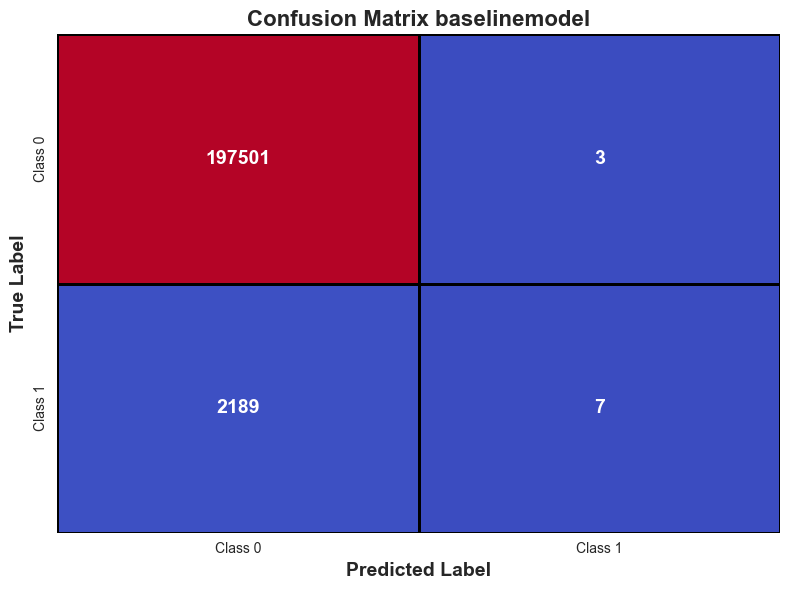

In [99]:
# Assume confusion_matrix_undersampling is the confusion matrix you want to plot

# Plotting with seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion_matrix_baselinemodel,
    annot=True,
    fmt="d",
    cmap="coolwarm",
    xticklabels=["Class 0", "Class 1"],
    yticklabels=["Class 0", "Class 1"],
    cbar=False,
    linewidths=1,
    linecolor='black',
    annot_kws={"size": 14, "weight": "bold"}
)

# Labels and title
plt.xlabel("Predicted Label", fontsize=14, weight='bold')
plt.ylabel("True Label", fontsize=14, weight='bold')
plt.title("Confusion Matrix baselinemodel", fontsize=16, weight='bold')

# Show the plot
plt.tight_layout()
plt.show()

In [70]:
# Recall, precision and f1-score
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1_score = 2 * (precision * recall) / (precision + recall)
fpr_baseline = fp / (fp + tn)
tpr_baseline = tp / (tp + fn)

print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1_score:.2f}")

Recall: 0.00
Precision: 0.70
F1 Score: 0.01


We can see that the model is totally biased towards the majority class. This is because the dataset is imbalanced. We can handle this by using weights or by undersampling the majority class.

## Using weights to handle class imbalance

In [47]:
total_count = df_transformed.count()
pos_count = df_transformed.filter(col("label") == 1).count()
neg_count = total_count - pos_count

# Compute class weights
pos_weight = total_count / (2.0 * pos_count)
neg_weight = total_count / (2.0 * neg_count)

# Add the weight column to the dataset
df_withWeights = df_transformed.withColumn(
    "weight", when(col("label") == 1, pos_weight).otherwise(neg_weight)
)

In [48]:
columns = df_withWeights.columns

# Remove the target column and weight column from the list of feature columns
columns.remove("label")
columns.remove("weight")

# Assemble features
assembler = VectorAssembler(inputCols=columns, outputCol="features")
data_transformed = assembler.transform(df_withWeights)

# Prepare the final dataset
dataset = data_transformed.select("features", "label", "weight")  # Include 'weight' column

# Split into training and testing datasets
train_data, test_data = dataset.randomSplit([0.8, 0.2], seed=42)

In [49]:
gbt_withWeights = GBTClassifier(featuresCol="features", labelCol="label", weightCol="weight", maxIter=30, maxDepth=3, stepSize=0.3, seed=42)

model_withWeights = gbt_withWeights.fit(train_data)

# We will not execute it because we already did it
'''
# paramGrid = ParamGridBuilder() \
#     .addGrid(gbt_withWeights.maxDepth, [3, 5, 7]) \
#     .addGrid(gbt_withWeights.maxIter, [10, 20, 30]) \
#     .addGrid(gbt_withWeights.stepSize, [0.1, 0.2, 0.3]) \
#     .build()
# 
# evaluator = BinaryClassificationEvaluator(
#     labelCol="label",
#     rawPredictionCol="rawPrediction",
#     metricName="areaUnderROC"  # Use AUC as the metric
# )
# 
# crossval = CrossValidator(
#     estimator=gbt_withWeights,
#     estimatorParamMaps=paramGrid,
#     evaluator=evaluator,
#     numFolds=3,  # Use 3-fold cross-validation
#     parallelism=2  # Number of threads to use
# )
# 
# cvModel = crossval.fit(train_data)
# 
# bestModel = cvModel.bestModel
# print(f"Best maxDepth: {bestModel.getMaxDepth()}")
# print(f"Best maxIter: {bestModel.getMaxIter()}")
# print(f"Best stepSize: {bestModel.getStepSize()}")
'''

predictions_withWeights = model_withWeights.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc_weights = evaluator.evaluate(predictions_withWeights)
print(f"Test AUC: {roc_auc_weights}")

24/12/03 23:06:28 WARN MemoryStore: Not enough space to cache rdd_1190_11 in memory! (computed 7.9 MiB so far)
24/12/03 23:06:28 WARN MemoryStore: Not enough space to cache rdd_1190_9 in memory! (computed 7.9 MiB so far)
24/12/03 23:06:28 WARN MemoryStore: Not enough space to cache rdd_1190_10 in memory! (computed 5.2 MiB so far)
24/12/03 23:06:28 WARN MemoryStore: Not enough space to cache rdd_1190_6 in memory! (computed 5.2 MiB so far)
24/12/03 23:06:28 WARN MemoryStore: Not enough space to cache rdd_1190_5 in memory! (computed 5.2 MiB so far)
24/12/03 23:06:28 WARN MemoryStore: Not enough space to cache rdd_1190_0 in memory! (computed 5.2 MiB so far)
24/12/03 23:06:28 WARN MemoryStore: Not enough space to cache rdd_1190_1 in memory! (computed 7.9 MiB so far)
24/12/03 23:06:28 WARN MemoryStore: Not enough space to cache rdd_1190_8 in memory! (computed 5.2 MiB so far)
24/12/03 23:06:28 WARN MemoryStore: Not enough space to cache rdd_1190_7 in memory! (computed 7.9 MiB so far)
24/12/03

Test AUC: 0.8855942483228949


In [50]:
# Calculate the ROC curve
results = predictions_withWeights.select(['label', 'rawPrediction'])
results_collect = results.collect()

fpr_weighted, tpr_weighted, _ = roc_curve([i['label'] for i in results_collect], [i['rawPrediction'][1] for i in results_collect])

# Calculate the AUC
roc_auc_weights = auc(fpr_weighted, tpr_weighted)

In [75]:
results = predictions_withWeights.withColumn("prediction", F.col("prediction").cast("double"))

tp = results.filter((F.col("label") == 1) & (F.col("prediction") == 1)).count()
tn = results.filter((F.col("label") == 0) & (F.col("prediction") == 0)).count()
fp = results.filter((F.col("label") == 0) & (F.col("prediction") == 1)).count()
fn = results.filter((F.col("label") == 1) & (F.col("prediction") == 0)).count()

confusion_matrix_weighted = pd.DataFrame(
    [[tn, fp], [fn, tp]],
    index=["Actual Negative", "Actual Positive"],
    columns=["Predicted Negative", "Predicted Positive"]
)

print(confusion_matrix_weighted)

                 Predicted Negative  Predicted Positive
Actual Negative              160007               37497
Actual Positive                 441                1755


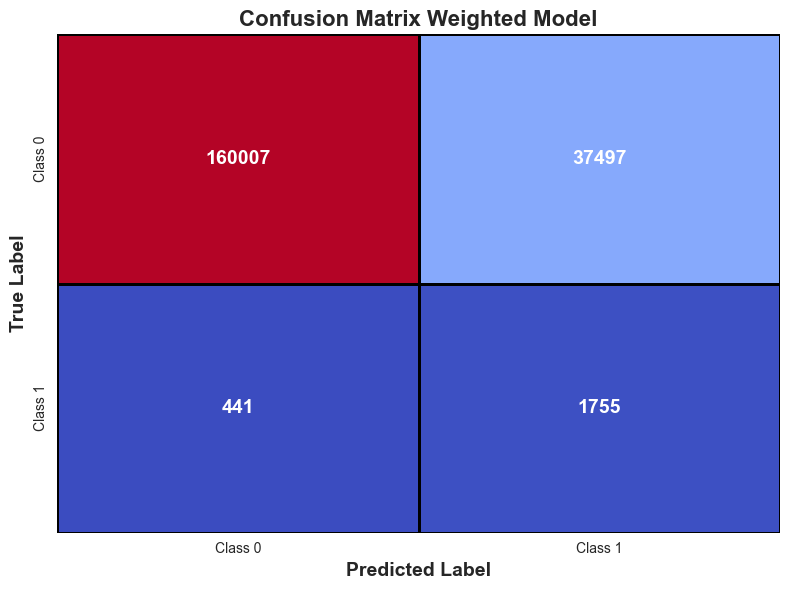

In [100]:
# Assume confusion_matrix_undersampling is the confusion matrix you want to plot

# Plotting with seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion_matrix_weighted,
    annot=True,
    fmt="d",
    cmap="coolwarm",
    xticklabels=["Class 0", "Class 1"],
    yticklabels=["Class 0", "Class 1"],
    cbar=False,
    linewidths=1,
    linecolor='black',
    annot_kws={"size": 14, "weight": "bold"}
)

# Labels and title
plt.xlabel("Predicted Label", fontsize=14, weight='bold')
plt.ylabel("True Label", fontsize=14, weight='bold')
plt.title("Confusion Matrix Weighted Model", fontsize=16, weight='bold')

# Show the plot
plt.tight_layout()
plt.show()

In [77]:
# Recall, precision and f1-score
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1_score = 2 * (precision * recall) / (precision + recall)
fpr_weighted = fp / (fp + tn)
tpr_weighted = tp / (tp + fn)

print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1_score:.2f}")

Recall: 0.80
Precision: 0.04
F1 Score: 0.08


## Training model with random undersampling

In [44]:
columns = df_transformed.columns
columns.remove("label")
assembler = VectorAssembler(inputCols=columns, outputCol='features')
data_transformed = assembler.transform(df_transformed)
# Prepare the final dataset
dataset = data_transformed.select('features', 'label')  # Ensure you have 'features' and 'label' columns
train_data, test_data = dataset.randomSplit([0.8, 0.2], seed=42)

In [45]:
# Under-sampling the majority class
majority_class = train_data.filter(train_data['label'] == 0)
minority_class = train_data.filter(train_data['label'] == 1)

# Setting the seed for reproducibility
seed = 42
# Downsample the majority class
majority_downsampled = majority_class.sample(False, minority_class.count() / majority_class.count(), seed)

# Combine the downsampled majority class with the minority class
df_undersampled = majority_downsampled.union(minority_class)

# Show the number of fraud and non-fraud transactions
df_undersampled.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 8899|
|  1.0| 8833|
+-----+-----+


In [46]:
# Declare base gbt model for cv
gbt_undersampling = GBTClassifier(featuresCol="features", labelCol="label", maxIter=30, maxDepth=3, stepSize=0.3, seed=42)
'''
# We will not execute it because we already did it
#paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5, 7]) \
    .addGrid(gbt.maxIter, [10, 20, 30]) \
    .addGrid(gbt.stepSize, [0.1, 0.2, 0.3]) \
    .build()

# Step 3: Set up the evaluator
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"  # Use AUC as the metric
)

# Step 4: Set up CrossValidator
crossval = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,  # Use 3-fold cross-validation
    parallelism=2  # Number of threads to use
)
# Step 5: Train the model with cross-validation

# Step 6: Extract the best model and parameters
bestModel = cvModel.bestModel
print(f"Best maxDepth: {bestModel.getMaxDepth()}")
print(f"Best maxIter: {bestModel.getMaxIter()}")
print(f"Best stepSize: {bestModel.getStepSize()}")
'''

model_undersampling = gbt_undersampling.fit(train_data)

predictions_undersampling = model_undersampling.transform(test_data)

evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

undersampled_auc = evaluator.evaluate(predictions_undersampling)

print(f"Test AUC: {undersampled_auc}")

24/12/03 23:04:58 WARN MemoryStore: Not enough space to cache rdd_657_1 in memory! (computed 7.9 MiB so far)
24/12/03 23:04:58 WARN MemoryStore: Not enough space to cache rdd_657_0 in memory! (computed 7.9 MiB so far)
24/12/03 23:04:58 WARN MemoryStore: Not enough space to cache rdd_657_3 in memory! (computed 5.2 MiB so far)
24/12/03 23:04:58 WARN MemoryStore: Not enough space to cache rdd_657_10 in memory! (computed 3.5 MiB so far)
24/12/03 23:04:58 WARN MemoryStore: Not enough space to cache rdd_657_5 in memory! (computed 5.2 MiB so far)
24/12/03 23:04:58 WARN MemoryStore: Not enough space to cache rdd_657_2 in memory! (computed 7.9 MiB so far)
24/12/03 23:04:58 WARN MemoryStore: Not enough space to cache rdd_657_4 in memory! (computed 7.9 MiB so far)
24/12/03 23:04:58 WARN MemoryStore: Not enough space to cache rdd_657_6 in memory! (computed 7.9 MiB so far)
24/12/03 23:04:58 WARN MemoryStore: Not enough space to cache rdd_657_9 in memory! (computed 7.9 MiB so far)
24/12/03 23:04:58 

Test AUC: 0.8535742920463412


Same hyperparameters as before but with random undersampling

In [138]:
results = predictions_undersampling.withColumn("prediction", F.col("prediction").cast("double"))

tp = results.filter((F.col("label") == 1) & (F.col("prediction") == 1)).count()
tn = results.filter((F.col("label") == 0) & (F.col("prediction") == 0)).count()
fp = results.filter((F.col("label") == 0) & (F.col("prediction") == 1)).count()
fn = results.filter((F.col("label") == 1) & (F.col("prediction") == 0)).count()
fpr_undersampled = fp / (fp + tn)
tpr_undersampled = tp / (tp + fn)

confusion_matrix_undersampling = pd.DataFrame(
    [[tn, fp], [fn, tp]],
    index=["Actual Negative", "Actual Positive"],
    columns=["Predicted Negative", "Predicted Positive"]
)

print(confusion_matrix_undersampling)

                 Predicted Negative  Predicted Positive
Actual Negative              197499                   5
Actual Positive                2187                   9


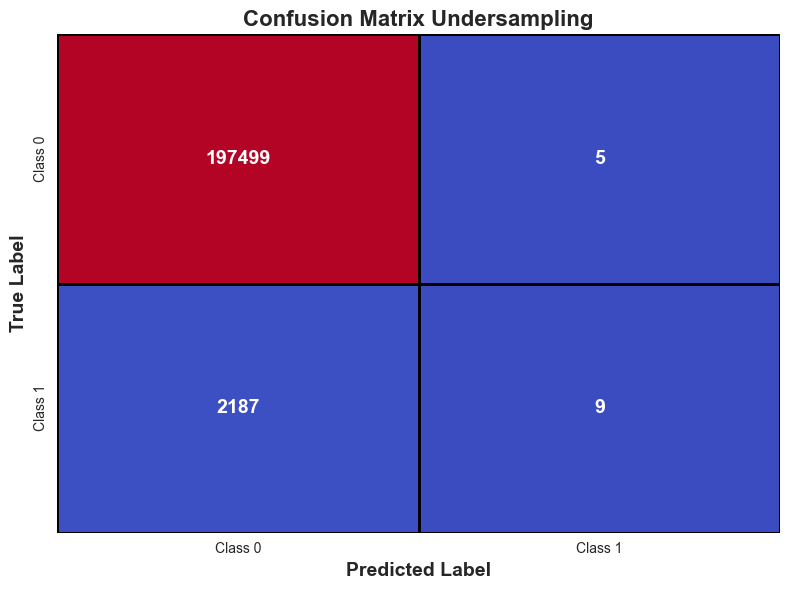

In [139]:
# Assume confusion_matrix_undersampling is the confusion matrix you want to plot
# Plotting with seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion_matrix_undersampling,
    annot=True,
    fmt="d",
    cmap="coolwarm",
    xticklabels=["Class 0", "Class 1"],
    yticklabels=["Class 0", "Class 1"],
    cbar=False,
    linewidths=1,
    linecolor='black',
    annot_kws={"size": 14, "weight": "bold"}
)

# Labels and title
plt.xlabel("Predicted Label", fontsize=14, weight='bold')
plt.ylabel("True Label", fontsize=14, weight='bold')
plt.title("Confusion Matrix Undersampling", fontsize=16, weight='bold')

# Show the plot
plt.tight_layout()
plt.show()

In [140]:
# Calculate the ROC curve
results = predictions_undersampling.select(['label', 'rawPrediction'])
results_collect = results.collect()

fpr_undersampled, tpr_undersampled, _ = roc_curve([i['label'] for i in results_collect], [i['rawPrediction'][1] for i in results_collect])

# Calculate the AUC
roc_auc_undersampled = auc(fpr_undersampled, tpr_undersampled)

In [141]:
# Recall, precision and f1-score
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1_score = 2 * (precision * recall) / (precision + recall)
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)


print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1_score:.2f}")

#Accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Accuracy: {accuracy:.2f}")

Recall: 0.00
Precision: 0.64
F1 Score: 0.01
Accuracy: 0.99


## Comparison of ROC Curves

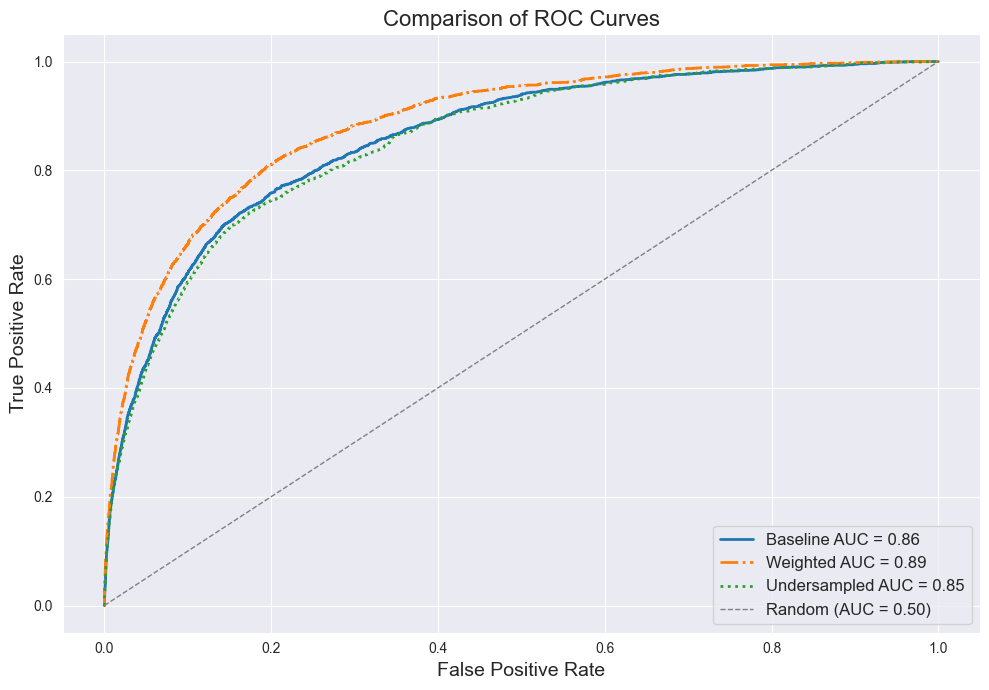

In [149]:
# Calculate AUC values if not already available
auc_baseline = auc(fpr_baseline, tpr_baseline)
auc_weighted = auc(fpr_weighted, tpr_weighted)
auc_undersampled = auc(fpr_undersampled, tpr_undersampled)

# Plot ROC Curves
plt.figure(figsize=(10, 7))
plt.plot(fpr_baseline, tpr_baseline, label=f'Baseline AUC = {auc_baseline:.2f}', linewidth=2)
plt.plot(fpr_weighted, tpr_weighted, linestyle='-.', label=f'Weighted AUC = {auc_weighted:.2f}', linewidth=2)
plt.plot(fpr_undersampled, tpr_undersampled, linestyle=':', label=f'Undersampled AUC = {auc_undersampled:.2f}', linewidth=2)

# Random (diagonal line)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1, label='Random (AUC = 0.50)')

# Labels and Legend
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Comparison of ROC Curves', fontsize=16)
plt.legend(loc='lower right', fontsize=12)

# Style adjustments
plt.grid(True)
plt.tight_layout()
plt.show()

# XAI

## Feature importance of the model with random undersampling

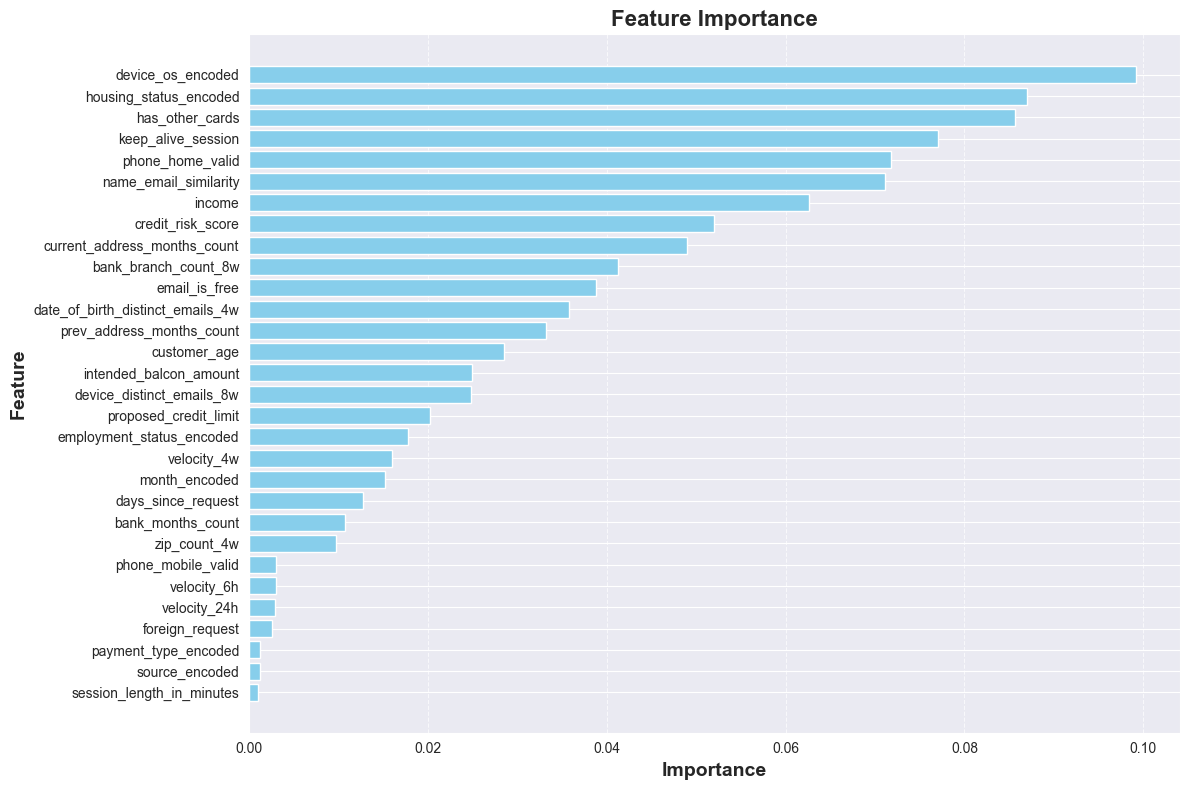

In [106]:
# Features importance
feature_importance_undersampling = model_undersampling.featureImportances

# Combine features and their importance into a list of tuples
feature_importance_tuples = [(feature, feature_importance_undersampling[i]) for i, feature in enumerate(columns)]

# Sort the tuples by importance in descending order
sorted_feature_importance = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)

# Separate the sorted features and their importance values
sorted_features, sorted_importance = zip(*sorted_feature_importance)

# Plot the sorted feature importance
plt.figure(figsize=(12, 8))
plt.barh(sorted_features, sorted_importance, color="skyblue")
plt.xlabel("Importance", fontsize=14, weight="bold")
plt.ylabel("Feature", fontsize=14, weight="bold")
plt.title("Feature Importance", fontsize=16, weight="bold")

# Add grid for better readability
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Reverse the order of y-axis labels for better visualization
plt.gca().invert_yaxis()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Feature importance of the model with weights

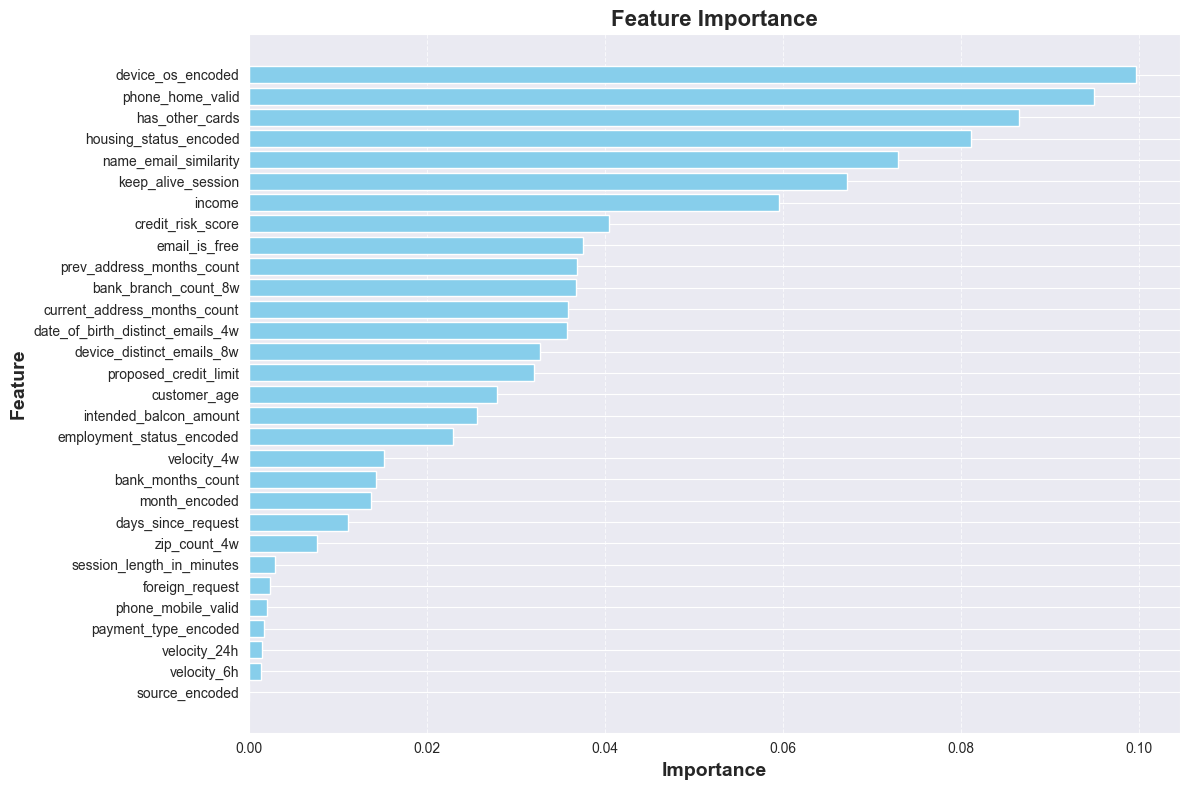

In [107]:
feature_importance_weighted = model_withWeights.featureImportances

# Combine features and their importance into a list of tuples
feature_importance_tuples = [(feature, feature_importance_weighted[i]) for i, feature in enumerate(columns)]

# Sort the tuples by importance in descending order
sorted_feature_importance = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)

# Separate the sorted features and their importance values
sorted_features, sorted_importance = zip(*sorted_feature_importance)

# Plot the sorted feature importance
plt.figure(figsize=(12, 8))
plt.barh(sorted_features, sorted_importance, color="skyblue")
plt.xlabel("Importance", fontsize=14, weight="bold")
plt.ylabel("Feature", fontsize=14, weight="bold")
plt.title("Feature Importance", fontsize=16, weight="bold")

# Add grid for better readability
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Reverse the order of y-axis labels for better visualization
plt.gca().invert_yaxis()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Feature importance of the baseline model

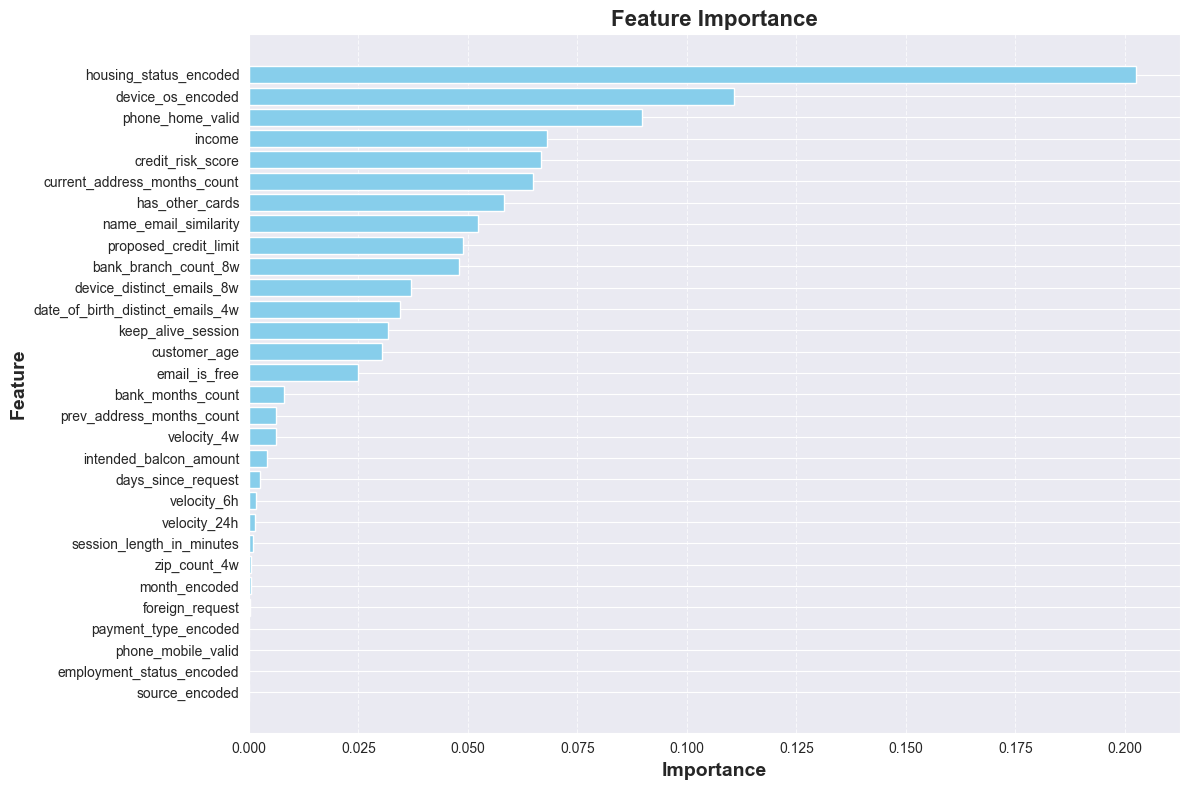

In [108]:
feature_importance_baseline = baseline_model.featureImportances

# Combine features and their importance into a list of tuples
feature_importance_tuples = [(feature, feature_importance_baseline[i]) for i, feature in enumerate(columns)]

# Sort the tuples by importance in descending order
sorted_feature_importance = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)

# Separate the sorted features and their importance values
sorted_features, sorted_importance = zip(*sorted_feature_importance)

# Plot the sorted feature importance
plt.figure(figsize=(12, 8))
plt.barh(sorted_features, sorted_importance, color="skyblue")
plt.xlabel("Importance", fontsize=14, weight="bold")
plt.ylabel("Feature", fontsize=14, weight="bold")
plt.title("Feature Importance", fontsize=16, weight="bold")

# Add grid for better readability
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Reverse the order of y-axis labels for better visualization
plt.gca().invert_yaxis()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## LIME

In [ ]:
import numpy as np
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row
from lime.lime_tabular import LimeTabularExplainer

In [53]:
train_pandas = train_data.limit(1000).toPandas()
test_pandas = test_data.limit(100).toPandas()

# Extract features and labels
features_pandas = np.array([row.features.toArray() for row in train_pandas.itertuples()])
labels_pandas = train_pandas['label']

In [59]:
def predict_proba_lime(instance):
    # Convert NumPy instance to a list of Spark Rows with the correct feature vector
    input_data = [Row(features=Vectors.dense(row.tolist())) for row in instance]

    # Create Spark DataFrame
    input_df = spark.createDataFrame(input_data)

    # Predict probabilities
    predictions = model_withWeights.transform(input_df)
    probas = predictions.select("probability").collect()

    # Extract and return probabilities as a NumPy array
    return np.array([proba["probability"] for proba in probas])  # Convert probabilities to NumPy array

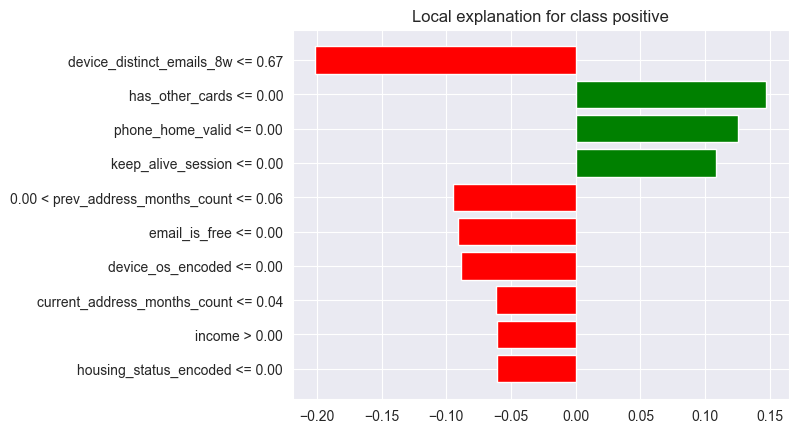

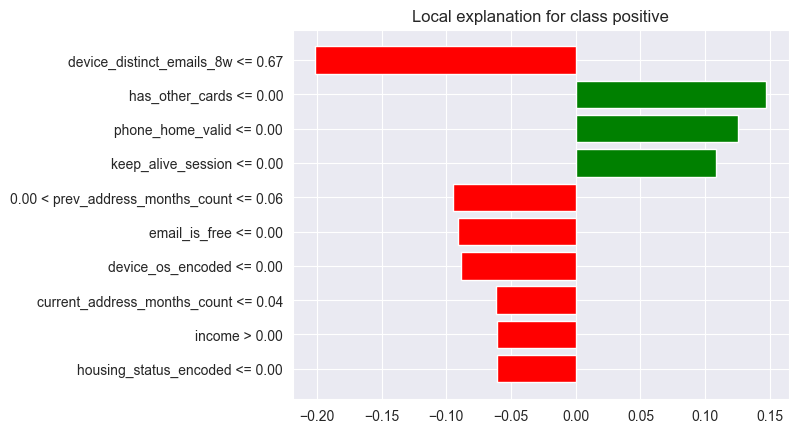

In [62]:
instance = features_pandas[0]  # First instance
explanation = explainer.explain_instance(instance, predict_proba_lime, num_features=10)

# Visualize the explanation
explanation.show_in_notebook()
explanation.as_pyplot_figure()

In [64]:
# Select one positive instance
positive_instance = (
    predictions_withWeights.filter(col("prediction") == 1)
    .select("features")
    .first()["features"]
)

# Convert the Spark Vector to a NumPy array for LIME
positive_instance_np = np.array(positive_instance.toArray())

# Explain the positive instance with LIME
explanation = explainer.explain_instance(positive_instance_np, predict_proba_lime, num_features=10)

# Visualize the explanation
explanation.show_in_notebook()
#explanation.as_pyplot_figure()